In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
pid = 193
qid = 7638
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

In [3]:
docs = Doc.objects.filter(query=q).values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

74968


9719

In [4]:
unseen_docs = docs.exclude(pk__in=seen).exclude(content__iregex='\w').distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(12444, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,393,None,Moving forward with species distributions,None,[Plant Sciences],0,0
1,501,None,"Competitive optimization models, attempting to...",adaptive dynamics; plant competition; resource...,[Plant Sciences],0,0
2,1259,None,"TOURISM AND CLIMATE CHANGE: IMPACTS, ADAPTATIO...",None,"[Hospitality, Leisure, Sport & Tourism; Sociol...",0,0
3,1843,None,Addressing the challenges of adaptation to cli...,None,None,0,0
4,1866,None,BETWEEN EXTREMES HEALTH EFFECTS of HEAT and COLD,None,"[Environmental Sciences; Public, Environmental...",0,0


In [7]:
tag, created = Tag.objects.get_or_create(
    query=q,
    title="No abstract"
)
print(tag, created)

if created:
    Through = Doc.tag.through
    dqs = [Through(doc_id=d,tag=tag) for d in unseen_docs.values_list('pk',flat=True)]
    Through.objects.bulk_create(dqs)

    tag.update_tag()
    
print(tag.doc_set.count())

No abstract False
12466


In [14]:

types = [
    "Article","Review","Journal Article","Journal Article; Review",
    'English Abstract; Journal Article','Article; Data Paper'
]

list(q.doc_set.exclude(tag=tag).values('wosarticle__dt').annotate(n=Count('pk')).order_by('-n'))

[{'n': 46977, 'wosarticle__dt': 'Article'},
 {'n': 4002, 'wosarticle__dt': 'Review'},
 {'n': 3223, 'wosarticle__dt': 'Book Chapter'},
 {'n': 2772, 'wosarticle__dt': 'Proceedings Paper'},
 {'n': 2527, 'wosarticle__dt': 'Conference Paper'},
 {'n': 614, 'wosarticle__dt': 'Article; Proceedings Paper'},
 {'n': 484, 'wosarticle__dt': 'Book'},
 {'n': 427, 'wosarticle__dt': None},
 {'n': 391, 'wosarticle__dt': 'Editorial Material'},
 {'n': 214, 'wosarticle__dt': 'Journal Article'},
 {'n': 160, 'wosarticle__dt': 'Article in Press'},
 {'n': 153, 'wosarticle__dt': 'Conference Review'},
 {'n': 125, 'wosarticle__dt': 'Review; Book Chapter'},
 {'n': 77,
  'wosarticle__dt': "Journal Article; Research Support, Non-U.S. Gov't"},
 {'n': 66, 'wosarticle__dt': 'Journal Article; Review'},
 {'n': 45, 'wosarticle__dt': 'Article; Book Chapter'},
 {'n': 34, 'wosarticle__dt': 'Article; Data Paper'},
 {'n': 33, 'wosarticle__dt': 'Editorial'},
 {'n': 29, 'wosarticle__dt': 'Note'},
 {'n': 24, 'wosarticle__dt': 'Er

In [21]:
wrongtype_docs = q.doc_set.exclude(wosarticle__dt__isnull=True).exclude(wosarticle__dt__in=types)

tag, created = Tag.objects.get_or_create(
    query=q,
    title="Wrong document type"
)
print(tag, created)

if created:
    Through = Doc.tag.through
    dqs = [Through(doc_id=d,tag=tag) for d in wrongtype_docs.values_list('pk',flat=True)]
    Through.objects.bulk_create(dqs)

    tag.update_tag()
    
print(tag.doc_set.count())


Wrong document type True
12415


In [7]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)

(8776, 7)


In [8]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,2469619,None,Changes resulting from a land consolidation pr...,None,None,0,0
1,760697,"Context Terrestrial ecosystems, including trop...",Fire regimes and forest resilience: alternativ...,Regime shift; Tipping point; Tropical forest e...,"[Ecology; Geography, Physical; Geosciences, Mu...",0,1
2,731304,Comparing agricultural management practices ac...,Land-users' perceptions and adaptations to cli...,Coping and adaptation strategies; Risk percept...,[Environmental Sciences; Environmental Studies],1,1
3,2469877,None,Studies on development of climate resilient ma...,None,None,0,0
4,1894570,To identify factors associated with farm-level...,"Factors associated with farm-level variation, ...",farm-level variability; smallholder mixed-farm...,[Environmental Studies],1,1


In [14]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

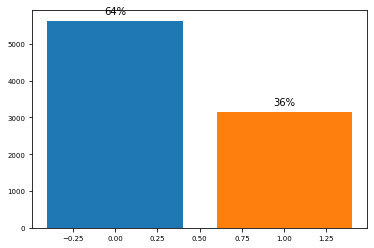

In [9]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [10]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=4, max_df=0.8, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
X = vec.fit_transform(df['title'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
from sklearn.model_selection import KFold
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    print(i)
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(X[k_train],y[k_train])
        predictions = clf.predict(X[k_test])
        model['e'].append(clf.score(X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


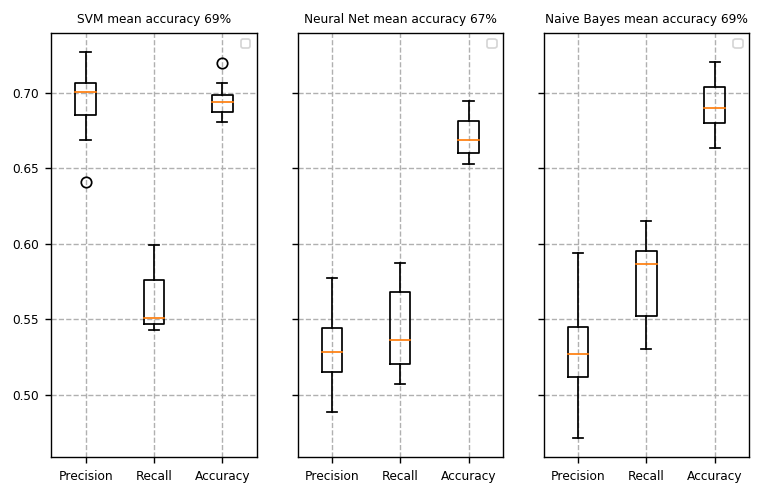

In [17]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [19]:
clf = SVC(kernel='linear',class_weight='balanced',probability=True)

clf.fit(X[seen_index],y[seen_index])

y_pred = clf.predict_proba(X[unseen_index])

3705
12479


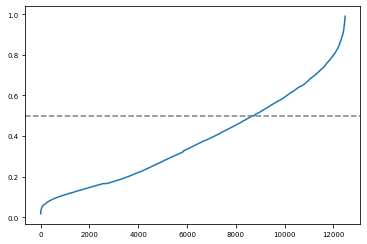

In [20]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])


In [22]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted title sample {}".format(now),
    query=q
)
tag.save()

max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  

    
tag.update_tag()
